Documentation

This notebook serves to give an example of how to use functions in this repository. 

In [52]:
import pandas as pd
import csv
import numpy as np
import requests as req
import re
from os import stat
import xarray as xr
import cfgrib
from os.path import exists
from netCDF4 import Dataset
import random

In [7]:
def get(url, params={}, output=None):
    """Takes a url ar well as optional wikipedia parameters and returnd a regex object containgin a string version of the html

    Args:
        url (str)       : A String of a wikipedia url
        params (str)    : (Optional) Wikipedia parameters, will change regex output
        output (str)    : (Optional) If passed, the html is saved to a file with $output as name

    Writes:
        html            :(Optional) Writes string from regex object to file if filname is passed

    Returns:
        regex object(obj): A regex object containing the html code as a string
    """
    r = req.get(url, params=params)

    if output != None:
        HTML_file = open(output, "w", encoding="utf-8")
        HTML_file.write("<!-- " + r.url + "--> \n")
        HTML_file.write(r.text)
        HTML_file.close()

    # print(r.url)
    return r


In [8]:
states = ["AK"] #, "AZ", "CA", "CO", "ID", "MT", "NV", "NM", "OR", "SD", "UT", "WA", "WY"]


def find_urls(regex, output=None):
    """Takes a string of a regex object or string containing html code, extracts all urls found in the article and

    Args:
        regex (obj)/(str): A String consisting of html code (from a wikipedia article) or a regex object containing a string of html
        Output(str)      : (Optional) Of passed, saved all urls to a file with name $output
    Writes:
        list            : (Optional) Is output variable is passed, list will be written
    Returns:
        list             : List of the all urls found in article without duplicates
    """
    r = regex
    # Determines wether a string or object is passed, creates a list of possible urls
    if type(r) == str:

        pat = r"(?<=href\=\").+?(?=\"|\#|\ t)"
        urls = re.findall(
            pat,
            r,
        )
    else:
        pat = r"(?<=href\=\").+?(?=\"|\#|\ t)"
        urls = re.findall(
            pat,
            r.text,
        )

    # Reject urls were used for toubleshooting and locating missed formats
    lst = []
    reject = []

    # For each url, tries to reconstruct links by comparing, then appending to string. Then appenging fixed link to output list. If not reconstructable, added to rejects
    for u in urls:

        if u[-5:] == "_hist":

            u = "https://wcc.sc.egov.usda.gov" + u
            # Partitioning the url is done in two steps due to http: and https: both containing ':'
            head, sep, tail = u.partition(":")
            head2, sep2, tail = tail.partition(":")
            string = head + sep + head2
            lst.append(string)

    urls = list(dict.fromkeys(lst))

    # Writes links to text file
    if output != None:
        with open(output, "w") as f:
            for x in urls:
                f.write(x + "\n")
        f.close()

    return lst



def scrap_data(save_loc=None):
    """
    Takes a file direcotry string as optional input, then scraps data from USDA SNOTEL measurements and saves 
    to specified location
    """
    mont_dict = {
        "Dec": "-12-",
        "Jan": "-01-",
        "Feb": "-02-",
        "Mar": "-03-",
        "Apr": "-04-",
        "May": "-05-",
        "Jun": "-06-",
        "Jul": "-07-",
        "Aug": "-08-",
        "Sep": "-08-",
    }

    # Base url
    url = "https://wcc.sc.egov.usda.gov/nwcc/rgrpt?report=snowmonth_hist&state="
    for state in states:
        r = get(url + state)
        urls = find_urls(r)

        t = get(urls[0])

        from bs4 import BeautifulSoup

        soup = BeautifulSoup(r.text, "html.parser")
        soup_table = soup.find_all("table")

        df = pd.read_html(str(soup_table[1]))[0]
        
        col_names = [
            "Year",
            "Jan_date",
            "Jan_SD",
            "Jan_SWE",
            "Feb_date",
            "Feb_SD",
            "Feb_SWE",
            "Mar_date",
            "Mar_SD",
            "Mar_SWE",
            "Apr_date",
            "Apr_SD",
            "Apr_SWE",
            "May_date",
            "May_SD",
            "May_SWE",
            "Jun_date",
            "Jun_SD",
            "Jun_SWE",
        ]
        super_lst = [["Date", "StationID", "Lat", "Long", "Elevation", "SD", "SWE"]]
        for i in range(len(urls)):
            if i % 10 == 0:
                print(state, i)
            t = get(urls[i])

            # Using B-Soup to create array of data in html file

            soup = BeautifulSoup(t.text, "html.parser")
            li = soup.prettify().split("\n")
            # The data starts after 62 lines
            li = li[62:]

            lif = []
            for l in li:
                lif.append(l.split(","))

            # Converting data table to pandas dataframe
            m_df = pd.DataFrame(lif)

            # Rather ugly regex-code, copy-pase code could be removed.
            try:
                m_df.columns = col_names

                for index, m in m_df.iterrows():
                    if m.Year != "":
                        if 2018 > float(m.Year) > 1980:
                            if m.Jan_SD != "" and m.Jan_SWE != "":
                                if float(m.Jan_SD) > 10 and float(m.Jan_SWE) > 0:
                                    yr = m.Year

                                    # Where no date is suplied, first day in month is assumed
                                    if m.Jan_date == "":
                                        d = "-01-01"
                                    else:
                                        mnt = mont_dict[m.Jan_date[0:3]]
                                        d = mnt + m.Jan_date[-2:]
                                        # Some december measurements are included in following year
                                        if m.Jan_date[0:3] == "Dec":
                                            yr = int(yr) - 1
                                    super_lst.append(
                                        [
                                            str(yr) + d,
                                            df.iloc[i, 2],
                                            df.iloc[i, 5],
                                            df.iloc[i, 6],
                                            df.iloc[i, 4],
                                            m.Jan_SD,
                                            m.Jan_SWE,
                                        ]
                                    )
                            if m.Feb_SD != "" and m.Feb_SWE != "":
                                if float(m.Feb_SD) > 10 and float(m.Feb_SWE) > 0:
                                    if m.Feb_date == "":
                                        d = "-02-01"
                                    else:
                                        mnt = mont_dict[m.Feb_date[0:3]]
                                        d = mnt + m.Feb_date[-2:]

                                        super_lst.append(
                                            [
                                                m.Year + d,
                                                df.iloc[i, 2],
                                                df.iloc[i, 5],
                                                df.iloc[i, 6],
                                                df.iloc[i, 4],
                                                m.Feb_SD,
                                                m.Feb_SWE,
                                            ]
                                        )
                            if m.Mar_SD != "" and m.Mar_SWE != "":
                                if float(m.Mar_SD) > 10 and float(m.Mar_SWE) > 0:
                                    if m.Mar_date == "":
                                        d = "-03-01"
                                    else:
                                        mnt = mont_dict[m.Mar_date[0:3]]
                                        d = mnt + m.Mar_date[-2:]

                                    super_lst.append(
                                        [
                                            m.Year + d,
                                            df.iloc[i, 2],
                                            df.iloc[i, 5],
                                            df.iloc[i, 6],
                                            df.iloc[i, 4],
                                            m.Mar_SD,
                                            m.Mar_SWE,
                                        ]
                                    )
                            if m.May_SD != "" and m.May_SWE != "":
                                if float(m.May_SD) > 10 and float(m.May_SWE) > 0:
                                    if m.May_date == "":
                                        d = "-05-01"
                                    else:
                                        mnt = mont_dict[m.May_date[0:3]]
                                        d = mnt + m.May_date[-2:]

                                    super_lst.append(
                                        [
                                            m.Year + d,
                                            df.iloc[i, 2],
                                            df.iloc[i, 5],
                                            df.iloc[i, 6],
                                            df.iloc[i, 4],
                                            m.May_SD,
                                            m.May_SWE,
                                        ]
                                    )
                            if m.Apr_SD != "" and m.Apr_SWE != "":
                                if float(m.Apr_SD) > 10 and float(m.Apr_SWE) > 0:
                                    if m.Apr_date == "":
                                        d = "-04-01"
                                    else:
                                        mnt = mont_dict[m.Apr_date[0:3]]
                                        d = mnt + m.Apr_date[-2:]

                                    super_lst.append(
                                        [
                                            m.Year + d,
                                            df.iloc[i, 2],
                                            df.iloc[i, 5],
                                            df.iloc[i, 6],
                                            df.iloc[i, 4],
                                            m.Apr_SD,
                                            m.Apr_SWE,
                                        ]
                                    )
                            if m.Jun_SD != "" and m.Jun_SWE != "":
                                if float(m.Jun_SD) > 10 and float(m.Jun_SWE) > 0:

                                    if m.Jun_date == "":
                                        d = "-06-01"
                                    else:
                                        mnt = mont_dict[m.Jun_date[0:3]]
                                        d = mnt + m.Jun_date[-2:]
                                    super_lst.append(
                                        [
                                            m.Year + d,
                                            df.iloc[i, 2],
                                            df.iloc[i, 5],
                                            df.iloc[i, 6],
                                            df.iloc[i, 4],
                                            m.Jun_SD,
                                            m.Jun_SWE,
                                        ]
                                    )
            # Print error message if unsuccesful
            except:
                print(str(i) + " Didnt work" + ", " + str(df.iloc[i, 2]))

        # Create seperate files for each state
        if save_loc==None:
            file = open("SNOTEL_" + state + ".csv", "w+", newline="")
        else:
            file = open(save_loc + "SNOTEL_" + state + ".csv", "w+", newline="")
        with file:
            write = csv.writer(file)
            write.writerows(super_lst)
        file.close()

    

scrap_data()

state
(267, 12) 267
[160]
AK 0
AK 1
AK 2
AK 3
AK 4
AK 5
AK 6
AK 7
AK 8
AK 9
AK 10
AK 11
AK 12
AK 13
AK 14
AK 15
AK 16
AK 17
AK 18
AK 19
AK 20
AK 21
AK 22
AK 23
AK 24
AK 25
AK 26
AK 27
AK 28
AK 29
AK 30
AK 31
AK 32
AK 33
AK 34
AK 35
AK 36
AK 37
AK 38
AK 39
AK 40
AK 41
AK 42
AK 43
AK 44
AK 45
AK 46
AK 47
AK 48
AK 49
AK 50
AK 51
AK 52
AK 53
AK 54
AK 55
AK 56
AK 57
57 Didnt work, nan
AK 58
AK 59
AK 60
AK 61
AK 62
AK 63
AK 64
AK 65
AK 66
AK 67
AK 68
AK 69
69 Didnt work, nan
AK 70
AK 71
AK 72
AK 73
AK 74
AK 75
AK 76
AK 77
AK 78
AK 79
AK 80
AK 81
AK 82
AK 83
AK 84
AK 85
AK 86
AK 87
87 Didnt work, nan
AK 88
88 Didnt work, nan
AK 89
AK 90
AK 91
AK 92
AK 93
AK 94
AK 95
AK 96
AK 97
97 Didnt work, nan
AK 98
AK 99
99 Didnt work, 34J07S
AK 100
AK 101
AK 102
AK 103
AK 104
AK 105
AK 106
AK 107
AK 108
AK 109
AK 110
AK 111
AK 112
AK 113
AK 114
AK 115
AK 116
AK 117
AK 118
AK 119
AK 120
AK 121
AK 122
AK 123
AK 124
AK 125
AK 126
AK 127
AK 128
AK 129
AK 130
AK 131
AK 132
AK 133
AK 134
AK 135
AK 136
AK 137
A

In [11]:
data = pd.read_csv("SNOTEL_AK.csv")
print(data)

             Date StationID    Lat    Long  Elevation  SD  SWE
0      1981-01-28     50M01  61.75 -150.89        160  18  4.0
1      1981-02-28     50M01  61.75 -150.89        160  32  6.4
2      1981-04-28     50M01  61.75 -150.89        160  16  5.0
3      1981-03-31     50M01  61.75 -150.89        160  25  7.0
4      1982-01-26     50M01  61.75 -150.89        160  24  6.0
...           ...       ...    ...     ...        ...  ..  ...
16188  2015-04-02     59O03  63.26 -159.57        100  29  6.7
16189  2016-01-30     59O03  63.26 -159.57        100  19  3.7
16190  2016-03-02     59O03  63.26 -159.57        100  31  5.8
16191  2016-04-01     59O03  63.26 -159.57        100  32  6.9
16192  2017-03-30     59O03  63.26 -159.57        100  23  4.2

[16193 rows x 7 columns]


In [51]:
def combine_station_data(save_loc = ""):

    # Loading dataframes for each state
    #AZ_df = pd.read_csv(save_loc + "SNOTEL_AZ.csv")
    AK_df = pd.read_csv(save_loc + "SNOTEL_AK.csv")
    #CA_df = pd.read_csv(save_loc + "SNOTEL_CA.csv")
    #CO_df = pd.read_csv(save_loc + "SNOTEL_CO.csv")
    #ID_df = pd.read_csv(save_loc + "SNOTEL_ID.csv")
    #MT_df = pd.read_csv(save_loc + "SNOTEL_MT.csv")
    #NM_df = pd.read_csv(save_loc + "SNOTEL_NM.csv")
    #NV_df = pd.read_csv(save_loc + "SNOTEL_NV.csv")
    #OR_df = pd.read_csv(save_loc + "SNOTEL_OR.csv")
    #SD_df = pd.read_csv(save_loc + "SNOTEL_SD.csv")
    #UT_df = pd.read_csv(save_loc + "SNOTEL_UT.csv")
    #WA_df = pd.read_csv(save_loc + "SNOTEL_WA.csv")
    #WY_df = pd.read_csv(save_loc + "SNOTEL_WY.csv")

    lst = [
        #AZ_df,
        AK_df,
        #CA_df,
        #CO_df,
        #ID_df,
        #MT_df,
        #NM_df,
        #NV_df,
        #OR_df,
        #SD_df,
        #UT_df,
        #WA_df,
        #WY_df,
    ]
    # Creating timeseries for covered time span
    ranger = pd.date_range(start="1980.01.01", end="1989.12.31")

    st_lst = []
    elev = []
    lat = []
    lon = []
    

    # Creating a list of station meta-data. (coordinates and elevation)
    for df in lst:
        for index, row in df.iterrows():
            if row.StationID in st_lst:
                pass
            else:
                st_lst.append(row.StationID)
                elev.append(row.Elevation)
                lat.append(row.Lat)
                lon.append(row.Long)

    # Saving station data
    st_inf = pd.DataFrame(st_lst)
    elev_inf = pd.DataFrame(elev)
    lat_inf = pd.DataFrame(lat)
    lon_inf = pd.DataFrame(lon)

    station_df = pd.concat([st_inf, elev_inf, lat_inf, lon_inf], axis=1)
    station_df.columns = ["StationID", "Elev", "Lat", "Lon"]
    station_df.set_index("StationID", inplace=True)

    station_df.to_csv("USA_Stations.csv")
    
    # Creating two matrixes for SD and SWE, dates as columns and stations as rows
    SD_df = pd.DataFrame(index=st_lst, columns=ranger)
    SWE_df = pd.DataFrame(index=st_lst, columns=ranger)

    for df in lst:

        for index, row in df.iterrows():
            
            if pd.to_datetime(row.Date).year <1990:

                SWE_df[str(row.Date)][row.StationID] = row.SWE
                SD_df[str(row.Date)][row.StationID] = row.SD

            

    # Converting to cm and saving the matrixes for further proccesing
    SWE_df = SWE_df*2.54
    SD_df = SD_df*2.54
    SWE_df.index.names = ['StationID']
    SD_df.index.names = ['StationID']
    SWE_df.to_csv("USA_SWE.csv")
    SD_df.to_csv("USA_SD.csv")


combine_station_data()


Now the two most important matrixes are collected, they are n*m matixes where n = the number of days between 1980.01.01 and 2018.07.01, and m = the number of stations. Stations only have data where measurements exists, the rest is NaN. 

In [15]:
SD = pd.read_csv("USA_SD.csv")
print(SD)

    Unnamed: 0  1980-01-01  1980-01-02  1980-01-03  1980-01-04  1980-01-05  \
0        50M01         NaN         NaN         NaN         NaN         NaN   
1       50M01S         NaN         NaN         NaN         NaN         NaN   
2       41P07S         NaN         NaN         NaN         NaN         NaN   
3       51K05S         NaN         NaN         NaN         NaN         NaN   
4       49M22S         NaN         NaN         NaN         NaN         NaN   
..         ...         ...         ...         ...         ...         ...   
213      50M02         NaN         NaN         NaN         NaN         NaN   
214      47Q08         NaN         NaN         NaN         NaN         NaN   
215      47Q09         NaN         NaN         NaN         NaN         NaN   
216      45M02         NaN         NaN         NaN         NaN         NaN   
217      59O03         NaN         NaN         NaN         NaN         NaN   

     1980-01-06  1980-01-07  1980-01-08  1980-01-09  ...  2018-

The next step is creating the features that will predict the SWE in the models. This is done using ERA5-Land data and snowclass. The script bellow is an example of a get request sent to the ECMWF API to get data. The waiting times are long and the recieved files are large. Id order to get all a total of 8 requests needed to be sent, one for each decade and one for each parameter (Hourly temperature and precipitation)
The ERA5-Land elevation can be derived from the geopotential found at: https://confluence.ecmwf.int/display/CKB/ERA5-Land%3A+data+documentation#ERA5Land:datadocumentation-parameterlistingParameterlistings

In [ ]:
def order_era5():
    import cdsapi

    """
    Retreiving ERA5 data requires a key and precise parameters. This is only meant to serve 
    as an example of how a request is supposed to look like. For me, era5 was only able
    to give 10 years of data at a time. Precipitation data and temperature data are optained seperatly.
    Read https://cds.climate.copernicus.eu/cdsapp#!/dataset/reanalysis-era5-land?tab=form for 
    further information on era5-land data download and key registration,
    """
    c = cdsapi.Client()

    c.retrieve(
        "reanalysis-era5-land",
        {
            "format": "netcdf",
            "variable": "total_precipitation",
            "year": [
                "1980",
                "1981",
                "1982",
                "1983",
                "1984",
                "1985",
                "1986",
                "1987",
                "1988",
                "1989",
            ],
            "month": [
                "01",
                "02",
                "03",
                "04",
                "05",
                "06",
                "07",
                "08",
                "09",
                "10",
                "11",
                "12",
            ],
            "day": [
                "01",
                "02",
                "03",
                "04",
                "05",
                "06",
                "07",
                "08",
                "09",
                "10",
                "11",
                "12",
                "13",
                "14",
                "15",
                "16",
                "17",
                "18",
                "19",
                "20",
                "21",
                "22",
                "23",
                "24",
                "25",
                "26",
                "27",
                "28",
                "29",
                "30",
                "31",
            ],
            "time": [
                "00:00",
                "01:00",
                "02:00",
                "03:00",
                "04:00",
                "05:00",
                "06:00",
                "07:00",
                "08:00",
                "09:00",
                "10:00",
                "11:00",
                "12:00",
                "13:00",
                "14:00",
                "15:00",
                "16:00",
                "17:00",
                "18:00",
                "19:00",
                "20:00",
                "21:00",
                "22:00",
                "23:00",
            ],
            "area": [
                49,
                -124,
                32,
                -103,
            ],
        },
        "download_total_precip_1980-1989.nc",
    )

In [49]:
def get_cor(tude, x):
    cnt = 0
    for d in tude:
        if d.values == round(x * 10) / 10:
            return cnt
        else:
            cnt += 1
    return 0


def era5_proccessing(stations, temp = True):
    """Processing of era5-land dataset, assuming 10 year intervals of era5-land data in netcdf format.
    For the script to work, ecmwflibs needs to be installed through 'pip install ecmwflibs'
    """
        
    if temp == True:
        df = xr.open_dataset("download_alaska_1980-1989.nc", engine="netcdf4")
        saveloc = "Data/temp/1980/"
        # Printing xarray metadata
        for v in df:
            print("{}, {}, {}".format(v, df[v].attrs["long_name"], df[v].attrs["units"]))

        # Finding start and stop time
        t0 = df.t2m[0, 0, 0].time.values
        t1 = df.t2m[-1, 0, 0].time.values
        # Creating timeseries of dates
        dates = pd.date_range(t0, t1, freq="d")
        
        for index, row in stations.iterrows():
            
            # Finding temperature using coordinates as index in xarray-df
            temp_df = df.t2m.sel(
                latitude=row.Lat, longitude=row.Lon, method="nearest"
            ).to_dataset()
            
            # Creating array of temperatures, reshaping so each row/col contains one list of 24 values
            # These values are hourly temperatures
            arr = temp_df.t2m.values
            arr = arr.reshape(-1, 24)

            # Calculating minimum and maximum temperature for each day, and storing separately
            min_ = np.min(arr, 1)
            max_ = np.max(arr, 1)

            # For each station, a file is created containing the date, min and max temperature.
            sdf = pd.DataFrame([dates, min_, max_]).T
            sdf.columns = ["time", "tmin", "tmax"]

            sdf.to_csv(saveloc + row.StationID + "_temp.csv", index=False)
            # These will have to be combined later.
    else:
        
        df = xr.open_dataset("download_alaska_1980-1989_pre.nc", engine="netcdf4")
        saveloc = "Data/tp/1980/"
        # Printing xarray metadata
        for v in df:
            print("{}, {}, {}".format(v, df[v].attrs["long_name"], df[v].attrs["units"]))

        # Finding start and stop time
        t0 = df.tp[0, 0, 0].time.values
        t1 = df.tp[-1, 0, 0].time.values
        # Creating timeseries of dates
        dates = pd.date_range(t0, t1, freq="d")

        for index, row in stations.iterrows():
            #Similar to previous code, but only precipitation sum is stored

            a = df.tp.sel(latitude=row.Lat, longitude=row.Lon, method="nearest").to_dataset()

            arr = a.tp.values
            arr = arr.reshape(-1, 24)
            sum_ = np.sum(arr, 1)

            sdf = pd.DataFrame([dates, sum_]).T
            sdf.columns = ["time", "tp"]
            sdf.to_csv(saveloc + row.StationID + "_tp.csv", index=False)


def elevation_data(stations):
    #Elevation of the ERA5-Land gridcell is found through the geopotential
    #Elevation from SNOTEL is given in feet and needs to be converted to meter

    elev_xar = xr.open_dataset("geo_1279l4_0.1x0.1.grib2_v4_unpack.nc", engine="netcdf4")
    # Printing xarray metadata
    for v in elev_xar:
        print("{}, {}, {}".format(v, elev_xar[v].attrs["long_name"], elev_xar[v].attrs["units"]))

    df = pd.DataFrame(columns=["StationID", "Elev", "Era5_elev"])
    for index, row in stations.iterrows():
        # Finding temperature using coordinates as index in xarray-df
        temp_df = elev_xar.z.sel(
            latitude=row.Lat, longitude=row.Lon+360, method="nearest"
        ).to_dataset()

        #Converting to meters
        
        df.loc[len(df)]=[row.StationID,temp_df.z.values[0]/9.80665,row.Elev*0.3048]       
        df.to_csv("USA_Elevations.csv", index=False)



In [50]:
stations = pd.read_csv("USA_Stations.csv")
elevation_data(stations)

z, Geopotential, m**2 s**-2


In [22]:
era5_proccessing(stations)

t2m, 2 metre temperature, K


In [28]:
era5_proccessing(stations, temp=False)

tp, Total precipitation, m


If several ERA5 timeseries are used, they need to be combined into one precipitation and one temperature file for each station. The following function is an example of how this can be done using the file structure used above.

In [ ]:
def combine_ERA_data(variable="tp"):
    stations = pd.read_csv("USA_stations.csv")

    for index, row in stations.iterrows():
        df_80 = pd.read_csv("Data/"+variable+"/1980/" + row.StationID + ".csv")
        df_90 = pd.read_csv("Data/"+variable+"/1990/" + row.StationID + ".csv")
        df_00 = pd.read_csv("Data/"+variable+"/2000/" + row.StationID + ".csv")
        df_10 = pd.read_csv("Data/"+variable+"/2010/" + row.StationID + ".csv")
        
        df = df_80.append(df_90.append(df_00.append(df_10)))
        df.to_csv("Data/tp/combined" + row.StationID + ".csv", index=False)
    

In [36]:
def ERA_matrix_creator():

    ranger = pd.date_range(start="1980.01.01", end="1989.12.31")
    stations = pd.read_csv("USA_stations.csv")
    df_min = pd.DataFrame(columns=ranger)
    df_max = pd.DataFrame(columns=ranger)
    df_tp = pd.DataFrame(columns=ranger)


    for index, row in stations.iterrows():
        print(row.StationID, index)

        #Transposing the matrix to get the met-data as rows.
        mat = pd.read_csv("Data/temp/1980/" + row.StationID + "_temp.csv").T

        df_min.loc[row.StationID] = mat.iloc[1, :].to_numpy()
        df_max.loc[row.StationID] = mat.iloc[2, :].to_numpy()

        mat = pd.read_csv("Data/tp/1980/" + row.StationID + "_tp.csv").T

        df_tp.loc[row.StationID] = mat.iloc[1, :].to_numpy()

    df_min.to_csv("USA_data_tmin.csv")
    df_max.to_csv("USA_data_tmax.csv")
    df_tp.to_csv("USA_data_tp.csv")


In [37]:
ERA_matrix_creator()

50M01 0
50M01S 1
41P07S 2
51K05S 3
49M22S 4
59M02 5
49M25 6
49M05 7
49M01 8
49M02 9
49M03 10
49M04 11
50LL24 12
50LL21 13
49L02 14
51R01S 15
49M28 16
49N07 17
48P01 18
50R03 19
47Q07 20
41P03 21
51K01 22
59O04 23
47Q03 24
45P02 25
47Q04 26
42Q02 27
51N01 28
41P02 29
42N01 30
42N01S 31
44N01 32
43M01 33
44Q05 34
46N01 35
47Q01 36
57Q02 37
43Q02 38
50S01 39
50S01S 40
46P04 41
57Q03 42
51M03 43
49L10S 44
45N04 45
43P01 46
43P02 47
34J02 48
46N05 49
51KK17 50
44M01 51
55P01 52
51K03 53
50N06 54
49S01 55
49O02 56
50N03 57
49O01 58
34J03 59
51K06 60
51R06 61
49L18 62
49L18S 63
46Q06 64
45O01 65
45O01S 66
34J04 67
49M10 68
54L02 69
48N02 70
45O05 71
45R01 72
47Q10 73
50KK09 74
46P02 75
56P01 76
44O02 77
49L09S 78
45O04S 79
51M02 80
43S03 81
49L14S 82
45N01 83
49Q02 84
47N02 85
54Q02 86
49M26 87
49M26S 88
49M08S 89
32H04 90
41PP8S 91
41N01 92
50L01 93
57Q01 94
51R02 95
50O01 96
52R02 97
52R04 98
62S01S 99
50L02S 100
49L03 101
45M05 102
50M04 103
31G09 104
46N02 105
52O01 106
52R01 107
46Q05 10

The snowclasses are obtained from Sturm et al. (2021): https://journals.ametsoc.org/view/journals/hydr/22/11/JHM-D-21-0070.1.xml, with the data available at: https://nsidc.org/data/nsidc-0768/versions/1

In [93]:
def add_snowclass(stations):
    df = xr.open_dataset("SnowClass_GL_05km_2.50arcmin_2021_v01.0.nc", engine="netcdf4")
    stations["Class"] = ""

    for i in range(stations.shape[0]):
        stations["Class"][i] = df.SnowClass.sel(
            lat=stations.iloc[i, 2],
            lon=stations.iloc[i, 3],
            method="nearest",
        ).values
        
    
    #Dictionary of snowclass codes.
    #Maritime is used twice since coastal stations were mislabeled as 8.0 (Ocean)
    g = {
        1.0: 1, #"Tundra",
        2.0: 2, #"Boreal Forest",
        3.0: 3, #"Maritime",
        4.0: 4, #"Ephemoral",
        5.0: 5, #"Praire",
        6.0: 6, #"Mountane Forest",
        7.0: 3, #"Ice",
        8.0: 3, #"Ocean",
        9.0: 3  #"Fill",
    }
    
    stations["Class"] = stations["Class"].replace(g)

    return stations


In [94]:
Stations = pd.read_csv("USA_Stations.csv")
Stations = Stations[["StationID", "Elev", "Lat", "Lon"]]
Stations = add_snowclass(Stations)
print(Stations)

Stations.to_csv("USA_Stations.csv", index=False)

c:\Python\lib\site-packages\ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if __name__ == '__main__':


    StationID  Elev    Lat     Lon  Class
0       50M01   160  61.75 -150.89      6
1      50M01S   160  61.75 -150.89      6
2      41P07S  1050  64.79 -141.23      2
3      51K05S  1653  59.86 -151.32      6
4      49M22S  2080  61.11 -149.67      2
..        ...   ...    ...     ...    ...
213     50M02   200  61.75 -150.05      6
214     47Q08  1900  65.57 -147.42      2
215     47Q09  1200  65.55 -147.67      1
216     45M02  2100  61.18 -145.69      1
217     59O03   100  63.26 -159.57      2

[218 rows x 5 columns]


Now that both SD/SWE data and ERA5 data for precipitation, min/max temperature, and elevation data is gathered it is time to create the final dataset that the models will use for training/prediction. The code used for this was developed by Ntokas et al. in their 2021 paper "Investigating ANN architectures and training to estimate snow water equivalent from snow depth" (https://hess.copernicus.org/articles/25/3017/2021/).

In [170]:
"""
Code developed by ntokas et al., edited by me. Fore more information see https://hess.copernicus.org/articles/25/3017/2021/
"""

import pickle


def get_met_data(Lat, Long, Station, year, par_dir):
    # get lat and long of each Nivo Station rounded on one digit
    Lat_Meteo = np.round(Lat, 1)
    Long_Meteo = np.round(Long, 1)
    
    # set up dates for meteo data
    start = datetime(year, 1, 1)
    if year == 2019:
        end = datetime(year, 4, 30)
    else:
        end = datetime(year, 12, 31)
    dates_Meteo = pd.date_range(start, end)
    
    # get precip, tmin, tmax for each Nivo Station for each day 
    num_station = len(Lat)
    num_dates = len(dates_Meteo)
    total_precip = np.empty((num_station, num_dates))
    total_precip[:] = np.nan
    tmax = np.empty((num_station, num_dates))
    tmax[:] = np.nan
    tmin = np.empty((num_station, num_dates))
    tmin[:] = np.nan
    
    if year == 2019:
        months = [1, 2, 3, 4]
    else:
        months = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]
    for month in months:
        data_tp = pickle.load(open(par_dir + "/00_data/saved_variables/ERA5/ERA5_data_tp_{0:02d}_{1:04d}".format(month, year), "rb"))  
        data_tmintmax = pickle.load(open(par_dir + "/00_data/saved_variables/ERA5/ERA5_data_tmaxtmin_{0:02d}_{1:04d}".format(month, year), "rb"))  
        date_start = datetime(year, month, 1)
        num_days = len(data_tp['Date'])
        idx_date, = np.where(dates_Meteo == np.datetime64(date_start))
        data_tp['Lat'] = np.round(data_tp['Lat'], decimals=1)
        data_tp['Long'] = np.round(data_tp['Long'], decimals=1)
        for i in range(num_station): 
            idx_lat = np.where(data_tp['Lat'] == Lat_Meteo[i])
            idx_lon = np.where(data_tp['Long'] == Long_Meteo[i])
            total_precip[i, int(idx_date):int(idx_date+num_days)] = np.squeeze(data_tp['TotalPrecip(mm)'][: ,idx_lat, idx_lon])
            tmin[i, int(idx_date):int(idx_date+num_days)] = np.squeeze(data_tmintmax['Min_t2m(C)'][: ,idx_lat, idx_lon])
            tmax[i, int(idx_date):int(idx_date+num_days)] = np.squeeze(data_tmintmax['Max_t2m(C)'][: ,idx_lat, idx_lon])
            
    dates_Meteo = dates_Meteo.values.astype('datetime64[D]')
    
    return total_precip, tmin, tmax, dates_Meteo

def frost_defrost(tmin_mod, tmax_mod, dates, nb_dates):
    Frost_NoDefrost = np.nonzero(np.logical_and(tmin_mod<=-1, tmax_mod<1).values)
    Frost_Defrost = np.nonzero(np.logical_and(tmin_mod<=-1, tmax_mod>=1).values)
    NoFrost_NoDefrost = np.nonzero(np.logical_and(tmin_mod>-1, tmax_mod<1).values)
    NoFrost_Defrost = np.nonzero(np.logical_and(tmin_mod>-1, tmax_mod>=1).values)

    episode = np.empty(nb_dates)
    episode[Frost_NoDefrost] = 1
    episode[Frost_Defrost] = 2
    episode[NoFrost_NoDefrost] = 3
    episode[NoFrost_Defrost] = 4
    count = 0 
    frost = 0
    result = np.zeros(nb_dates)
    for i in range(nb_dates):
        date = dates[i]
        if (date.month == 9) and (date.day == 1):
            count = 0
        if episode[i] == 1: 
            frost = 1
        elif episode[i] == 2: 
            count += 1
            frost = 0
        elif episode[i] == 3: 
            count = count 
            frost = frost
        elif episode[i] == 4: 
            if frost == 1:
                count += 1
                frost = 0
        result[i] = count 
    result_df = pd.DataFrame(result, index=dates)
    return result_df

def num_without_snow(tmax_mod, total_precip_mod, dates, nb_dates):
    result = np.zeros(nb_dates)
    logic = ~np.logical_and(tmax_mod<=0, total_precip_mod>=3)
    count = 0
    for i in range(nb_dates):
        date = dates[i]
        if (date.month == 9) and (date.day == 1):
            count = 0
        if logic[i] == 1:
            count += 1
        result[i] = count
    result_df = pd.DataFrame(result, index=dates)   
    return result_df

def pos_degrees(tmid, dates, nb_dates):
    result = np.zeros(nb_dates)
    tmid_mod = np.where(tmid > 0, tmid, 0)
    count = 0
    for i in range(nb_dates):
        date = dates[i]
        if (date.month == 9) and (date.day == 1):
            count = 0
        count = count + tmid_mod[i]
        result[i] = count
    result_df = pd.DataFrame(result, index=dates)   
    return result_df

def num_layer(delta, th, total_precip_solid, dates, nb_dates):
    result = np.zeros(nb_dates)
    count = 0
    new_layer = 0
    cumul = np.sum(total_precip_solid[:delta])
    if cumul > th: 
        count += 1
        new_layer = 1
        result[:delta] = 1
    for i in range(delta, nb_dates):
        date = dates[i]
        if (date.month == 9) and (date.day == 1):
            count = 0
        if (new_layer == 0) and (total_precip_solid[i] > 0):
            count += 1
            new_layer = 1
        cumul = np.sum(total_precip_solid[(i-delta) + 1 :i + 1])
        if (new_layer == 1) and (cumul <= th):
            new_layer = 0
        result[i] = count 
    result_df = pd.DataFrame(result, index=dates)   
    return result_df

def age_snow_cover(d, tmid, total_precip_solid):
    dt = pd.to_datetime(d)
    month = dt.month
    year = dt.year
    if month < 9:
        year = year - 1
    else:
        year = year
    sep_1st = date(year, 9, 1)
    sep_1st = str(year) + "-09-01"
    tmid_mod = tmid.loc[sep_1st:d]
    nb = len(tmid_mod)
    total_precip_mod_solid = total_precip_solid[sep_1st:d]
    cuml = np.sum(total_precip_mod_solid)
    age = np.arange(nb, 0, -1)
    age_acc = np.sum(age * total_precip_mod_solid)
    result = age_acc / cuml
    return result, total_precip_mod_solid, cuml, nb


In [78]:
"""
Code developed by ntokas et al., edited by me. Fore more information see https://hess.copernicus.org/articles/25/3017/2021/
"""

def feature_calculations(SWE, SD, total_precip, tmin, tmax, Stations, savefile, elevations):
    # load Canadian historical sonw survey (CHSS): dictionary with Station ID, longitude, latitude, elevation,
    #                                              2 dim matrix (Station ID x dates) for SWE, SD, density
    
    import datetime
    import pandas as pd

    # Load associated meteorological data
    total_precip = pd.read_csv("USA_data_tp.csv", index_col=False)
    total_precip = total_precip * 1000


    print("Snow survey data and meteorological data loaded")

    import numpy as np
    import pickle


    # correction of temperature because of different elevation of station and grid
    # load elevation of grid points
    # round Longitude and Latitude to the first decimal to fit them together (ERA5 lowest resolution is 0.1x0.1)

    Lat_station = Stations["Lat"].round(decimals=1)
    Long_station = Stations["Lon"].round(decimals=1)
    # apply temperature correction
    for i in Lat_station.index:
        elev_grid = elevations["Era5_elev"].loc[i]
        elev_st = elevations["Elev"].loc[i]
        tmin.iloc[i, :] = tmin.iloc[i, :] + ((elev_st - elev_grid) / 1000 * (-6)) - 273.15
        tmax.iloc[i, :] = tmax.iloc[i, :] + ((elev_st - elev_grid) / 1000 * (-6)) - 273.15


    # load function to calculate input varibles from meteorological data
    import _input_calc
    import pandas as pd
    from datetime import datetime, timedelta

    # create dataset for input;
    # one line represents one records of SD and the associated input varibles, which will be calculated in the following
    df_dataset = pd.DataFrame(
        columns=[
            "StationID",
            "Date",
            "SD",
            "SWE",
            "Elev",
            "Lat",
            "Long",
            "DOY",
            "days without snow",
            "number frost-defrost",
            "accum pos degrees",
            "average age SC",
            "number layer",
            "accum solid precip",
            "accum solid precip in last 10 days",
            "total precip last 10 days",
            "average temp last 6 days",
            "snowclass"
        ]
    )

    start_year = pd.to_datetime(tmin.columns[0]).year
    end_year = pd.to_datetime(tmin.columns[-1]).year
    range_year = np.arange(start_year + 1, end_year + 1)
    dates_Meteo = pd.to_datetime(tmin.columns)
    nb_dates = len(dates_Meteo)


    # count to print how may stations are left
    count = len(Stations.index)
    line = 0
    for St in Stations.index:
        

        count = count - 1
        if count % 25 == 0:
            print(datetime.now())
            print("{} left till loop over stations done".format(count))
            print("Data points created: ", line)
        # calculate average temeperature
        tmid = (tmin.iloc[St, :] + tmax.iloc[St, :]) / 2

        # logistic regression to separate precipitation into silod and liquid parts
        # tested over the northern hemnisphere by
        # ('Spatial variation of the rain–snow temperature threshold across the Northern Hemisphere' Jennings et al. 2018)
        probab_snow = 1 / (1 + np.exp(-1.54 + 1.24 * tmid))
        total_precip_solid = total_precip.iloc[St, :] * probab_snow

        # generate frost-defrost timeline for concerning station;
        # -1°C for the maximal temp and 1°C for the minimal temperature are the threshold for freezing and thawing, respectively
        frost_defrost_vect = _input_calc.frost_defrost(
            tmin.iloc[St, :], tmax.iloc[St, :], dates_Meteo, nb_dates
        )
        # print(tmin.iloc[St, 0])
        # generate timeline of number of days without snow for concerning station
        nb_days_without_snow_vect = _input_calc.num_without_snow(
            tmax.iloc[St, :], total_precip.iloc[St, 1:], dates_Meteo, nb_dates
        )
        # generate timeline of accumulated posiitve degrees since beginning of winter (1. of September)
        pos_degree_vect = _input_calc.pos_degrees(tmid, dates_Meteo, nb_dates)
        # generate timeline of number of layers;
        # a new layer is considered to be created if there is a 3-days gap
        # with less than 10mm of (accumulated over these 3 days) solid precipitation
        num_layer_vec = _input_calc.num_layer(
            3, 10, total_precip_solid, dates_Meteo, nb_dates
        )

        # loop over the dates for the concerning station
        for dat in SWE.columns:
            if dat != "StationID":

                if ~np.isnan(SWE.loc[St, dat]):
                    # preparation

                    ndRow = np.empty((1, len(df_dataset.columns)))
                    ndRow[:] = np.nan
                    row = pd.DataFrame(ndRow, columns=df_dataset.columns)
                    df_dataset = df_dataset.append(row, ignore_index=True)

                    # add Station ID
                    df_dataset.iloc[line]["StationID"] = Stations["StationID"][St]
                    # add Lat and Long
                    df_dataset.iloc[line]["Lat"] = Stations.loc[St, "Lat"]
                    df_dataset.iloc[line]["Long"] = Stations.loc[St, "Lon"]
                    # add date of measurement
                    df_dataset.iloc[line]["Date"] = dat
                    # add station elevation
                    df_dataset.iloc[line]["Elev"] = elevations.loc[St, "Elev"]
                    # add snow bulk denisty
                    # df_dataset.iloc[line]['Den'] = CHSS['Den(kg/m3)'].iloc[St, dat]
                    # add SWE
                    df_dataset.iloc[line]["SWE"] = SWE.loc[St, dat]
                    # add snow depth
                    df_dataset.iloc[line]["SD"] = SD.loc[St, dat]
                    # days without snow since 1st of august
                    df_dataset.iloc[line][
                        "days without snow"
                    ] = nb_days_without_snow_vect.loc[dat][0]
                    # print(nb_days_without_snow_vect)
                    # number of frost-defrost events since 1st of September
                    df_dataset.iloc[line]["number frost-defrost"] = frost_defrost_vect.loc[
                        dat, 0
                    ]
                    # calculate the accumulated temperature from 1st of September till record
                    df_dataset.iloc[line]["accum pos degrees"] = pos_degree_vect.loc[dat][0]
                    # calculate the average age of the snow cover
                    # Try/except to deal with division by zero that can occur
                    try:
                        (
                            df_dataset.iloc[line]["average age SC"],
                            total_precip_mod_solid,
                            cumul,
                            nb_days,
                        ) = _input_calc.age_snow_cover(dat, tmid, total_precip_solid)
                    except:
                        continue
                    # add number of days since 1st of September
                    df_dataset.iloc[line]["DOY"] = nb_days
                    # estimate the number of layers in the snow cover
                    df_dataset.iloc[line]["number layer"] = num_layer_vec.loc[dat][0]
                    # calculate accumlated solid precipitation from 1st September till record
                    df_dataset.iloc[line]["accum solid precip"] = cumul
                    # calculate accumlated solid precipitation in the last 10 days before the record
                    df_dataset.iloc[line]["accum solid precip in last 10 days"] = np.sum(
                        total_precip_mod_solid[-10:]
                    )
                    # calculate accumlated total precipitation in the last 10 days before the record
                    dat_Ndays = pd.to_datetime(dat) - timedelta(days=10)
                    dat_Ndays = (
                        str(dat_Ndays.year)
                        + "-"
                        + "{:02d}".format(dat_Ndays.month)
                        + "-"
                        + "{:02d}".format(dat_Ndays.day)
                    )
                    df_dataset.iloc[line]["total precip last 10 days"] = np.sum(
                        total_precip.loc[St, dat:dat_Ndays:-1]
                    )
                    # calculate average temperature in the last 6 days before the record
                    dat_Ndays = pd.to_datetime(dat) - timedelta(days=6)
                    dat_Ndays = (
                        str(dat_Ndays.year)
                        + "-"
                        + "{:02d}".format(dat_Ndays.month)
                        + "-"
                        + "{:02d}".format(dat_Ndays.day)
                    )

                    df_dataset.iloc[line]["average temp last 6 days"] = np.mean(
                        tmid.loc[dat:dat_Ndays:-1]
                    )

                    # add snowclass
                    df_dataset.iloc[line]["snowclass"] = Stations.loc[St, "Class"]
                    # increase line count
                    line += 1


    df_dataset.to_csv("USA_dataset.csv", index=False)

In [95]:
Stations = pd.read_csv("USA_Stations.csv")
SWE = pd.read_csv("USA_SWE.csv",index_col=False)*10
SD = pd.read_csv("USA_SD.csv",index_col=False)
total_precip = pd.read_csv("USA_data_tp.csv", index_col=False)*1000
tmin = pd.read_csv("USA_data_tmin.csv", index_col=0)
tmax = pd.read_csv("USA_data_tmax.csv", index_col=0)
savefile = "Dataset.csv"

elevations = pd.read_csv("USA_Elevations.csv")


feature_calculations(SWE, SD, total_precip, tmin, tmax, Stations, savefile, elevations)

Snow survey data and meteorological data loaded
2022-11-11 02:33:31.779514
200 left till loop over stations done
Data points created:  238
2022-11-11 02:34:05.560793
175 left till loop over stations done
Data points created:  675
2022-11-11 02:34:37.935239
150 left till loop over stations done
Data points created:  1004
2022-11-11 02:35:09.979812
125 left till loop over stations done
Data points created:  1290
2022-11-11 02:35:41.977475
100 left till loop over stations done
Data points created:  1563
2022-11-11 02:36:13.831900
75 left till loop over stations done
Data points created:  1819
2022-11-11 02:36:46.013712
50 left till loop over stations done
Data points created:  2084
2022-11-11 02:37:19.351826
25 left till loop over stations done
Data points created:  2477
2022-11-11 02:37:51.528149
0 left till loop over stations done
Data points created:  2764


The models that will be used are XGBoost and Random forrest regressor, as well as two linear regressiond developed by Sturm et al. and Jonas et al. 

Sturm et al.:
https://journals.ametsoc.org/view/journals/hydr/11/6/2010jhm1202_1.xml

Jonas et al.:
(https://jannefiluren.github.io/docs/Jonas2009%20-%20Estimating%20the%20snow%20water%20equivalent%20from%20snow%20depth%20measurements%20in%20the%20Swiss%20Alps.pdf)

Last step before running algorithm, designating 30% of the stations to be used for validating the model.

In [106]:
df = pd.read_csv("USA_Dataset.csv", index_col=False).dropna()
print (df.shape)
unique = list(df["StationID"].unique())

val_unique = random.sample(unique, int(len(unique) * 0.30))
val_df = pd.DataFrame()
print(len(unique), len(val_unique))
i = 1
for x in val_unique:
    adf = df.loc[(df.StationID == x)]
    df = df.loc[(df.StationID != x)]

    val_df = val_df.append(adf)
    i = i + 1

print(val_df.shape, df.shape, val_df.shape[0] + df.shape[0])

val_df.to_csv("test.csv", index=False)
df.to_csv("train.csv", index=False)

(2764, 18)
103 30
(777, 18) (1987, 18) 2764


In [60]:
import time
import xgboost as xgb
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.base import TransformerMixin
from sklearn.metrics import r2_score

In [137]:

class DataFrameImputer(TransformerMixin):
    def fit(self, X, y=None):
        self.fill = pd.Series(
            [
                X[c].value_counts().index[0]
                if X[c].dtype == np.dtype("O")
                else X[c].median()
                for c in X
            ],
            index=X.columns,
        )
        return self

    def transform(self, X, y=None):
        return X.fillna(self.fill)


def xg(params, X_train, y_train):
    """
    Takes a list of model parameters, training X values, and training y values as input and returnes a
    trained XGBoost model.
    """
    if len(params) != 4 or params == None:
        params = [9, 1000, 0.035, True]
        print("Using default xg parameters")
    model = xgb.XGBRegressor(
        max_depth=params[0],
        n_estimators=params[1],
        learning_rate=params[2],
        tree_method="gpu_hist",
        single_precision_histogram=params[3],
    ).fit(X_train, y_train)
    return model


def rf(params, X_train, y_train):
    """
    Takes a list of model parameters, training X values, and training y values as input and returnes a
    trained random forest model.
    """
    
    if len(params) != 7 or params == None:
        params = [60, None, 12, 3, 1, True, True]
        print("Using default rf parameters")
    model = RandomForestRegressor(
        n_estimators=params[0],
        max_features=params[1],
        max_depth=params[2],
        min_samples_split=params[3],
        min_samples_leaf=params[4],
        bootstrap=params[5],
        oob_score=params[6],
    ).fit(X_train, y_train)
    return model


def run_model(method, df, feature_columns, target, test=[], params=None):
    """
    Function takes m*n pandas dataframe (df) and method (with optional parameters) as inputs and gives
    predictions as output.
    feature columns (lst) = list with length m with names of columns containing predictors
    target (str) = name of target variable

    Returns 1xn pandas dataframe of predicted values
    """
    big_X = df[feature_columns]
    # big_X_imputed = DataFrameImputer().fit_transform(big_X)
    big_Y = df[target]

    le = LabelEncoder()
    big_X_imputed = big_X[feature_columns].apply(LabelEncoder().fit_transform)

    if isinstance(test, pd.DataFrame) != True:
        X_train, X_test, y_train, y_test = train_test_split(
            big_X_imputed, big_Y, test_size=0.33, random_state=0
        )
    else:
        X_train = big_X_imputed
        X_test = test[feature_columns].apply(LabelEncoder().fit_transform)
        y_train = big_Y
        y_test = test["SWE"]

    # ___________________________
    start = time.time()
    if method == "xg":
        model = xg(params, X_train, y_train)

    elif method == "rf":
        model = rf(params, X_train, y_train)

    time2compute = time.time() - start
    # ______________________________

    predictions = model.predict(X_test)

    """print(
        "Calculation finished in "
        + str(time2compute)
        + " using "
        + method
        + " with an R2 score of "
        + str(r2_score(predictions, y_test))
    )"""


    return predictions, r2_score(predictions, y_test)

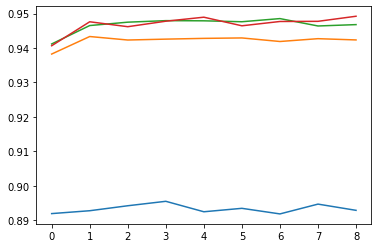

In [ ]:
import warnings
warnings.filterwarnings("ignore")
#Dont use this, only here for clean prints

method = "rf"
feature_columns = [
    "SD",
    "Elev",
    "Lat",
    "Long",
    "DOY",
    "days without snow",
    "number frost-defrost",
    "accum pos degrees",
    "average age SC",
    "number layer",
    "accum solid precip",
    "accum solid precip in last 10 days",
    "total precip last 10 days",
    "average temp last 6 days",
    "snowclass"
]
target = "SWE"
df = pd.read_csv("train.csv")
test = pd.read_csv("test.csv")

#Testing for n_estimators and max depth
params = [0, None, 0, 3, 1, True, True]

lst = [[]]
for i in range(1, 5):
    for j in range(1, 10):
        results = run_model(method, df, feature_columns, target, test=[], params=[int(j*10), None, int(i*3), 3, 1, True, True])
        lst[i-1].append(results[-1])
    lst.append([])

import matplotlib.pyplot as plt

for x in lst:
    plt.plot(x)
plt.show()

In [145]:
method = "xg"
lst = [[]]
for i in range(1, 10):
    for j in range(1, 10):
        results = run_model(method, df, feature_columns, target, test=[], params=[int(i), int(j*10), 0.035, True])
        lst[i-1].append(results[-1])
    lst.append([])
df = pd.DataFrame(lst)
df[df<0] = 0 
for x in df:
    plt.plot(x)
plt.show()

TypeError: '<' not supported between instances of 'list' and 'int'